In [1]:
!pip install sqlalchemy
!pip install pyodbc

In [2]:
from sqlalchemy import create_engine, MetaData, Table, inspect
import pandas as pd
import numpy as np 
import scipy.stats as st
import matplotlib.pyplot as plt

In [6]:
#define engine function
def new_engine(dialect, server, database, user=None, password=None, integrated_security=True):
    if integrated_security:
        # for windows auth
        eng = f"{dialect}://{server}/{database}?trusted_connection=yes&driver=ODBC+Driver+17+for+SQL+Server"
    else:
        # for sql server auth
        eng = f"{dialect}://{user}:{password}@{server}/{database}?driver=ODBC+Driver+17+for+SQL+Server"
    print(eng)
    return create_engine(eng)

In [7]:
#specify connection
engine = new_engine('mssql', 'LAPTOP-OHJEPB0D', 'AdventureWorks2022', integrated_security=True)
#servers: LAPTOP-OHJEPB0D, MEGAPC



mssql://LAPTOP-OHJEPB0D/AdventureWorks2022?trusted_connection=yes&driver=ODBC+Driver+17+for+SQL+Server


In [8]:
#actually connect to database
connect = engine.connect()

In [6]:
# FINDING PRODUCT CATEGORIES, 37 in total, query top sales, put into piechart?
categories = pd.read_sql(sql="""
SELECT Name 
FROM Production.ProductSubcategory
""", con=connect)
categories.head(40)

,Name
0,Bib-Shorts
1,Bike Racks
2,Bike Stands
3,Bottles and Cages
4,Bottom Brackets
5,Brakes
6,Caps
7,Chains
8,Cleaners
9,Cranksets


In [9]:
#querying as dataframe using pandas, format to avoid scientific notations
#find top revenue generating products using a CTE, change ORDER BY depending on situation
top_rev = pd.read_sql(sql="""
WITH TotalRevenue AS (
SELECT 
	  C.Name
	, C.ProductID
	, C.StandardCost
	, C.ListPrice
	,
		CASE
		WHEN C.ListPrice = 0 THEN 0
		ELSE (SUM(C.Listprice) - SUM(C.Standardcost)) / SUM(C.ListPrice) * 100 
		END AS ProfitMarginPct
	, SUM(C.Listprice) - SUM(C.StandardCost) AS Revenue
FROM Production.Product AS C
GROUP BY C.Name, C.ProductID, C.ListPrice, C.StandardCost
)
SELECT A.ProductID
	, B.Name
	, SUM(A.OrderQty) AS TotalUnitsSold
	, B.StandardCost
	, B.ListPrice
	, B.ProfitMarginPct
	, SUM(B.Revenue) AS TotalRev
FROM Sales.SalesOrderDetail AS A
	INNER JOIN TotalRevenue AS B
		ON A.ProductID = B.ProductID
GROUP BY A.ProductID, B.Name, B.ListPrice, B.StandardCost, B.ProfitMarginPct
ORDER BY TotalRev DESC;
""", con=connect)
pd.options.display.float_format = '{:.0f}'.format
top_rev.head(10)

,ProductID,Name,TotalUnitsSold,StandardCost,ListPrice,ProfitMarginPct,TotalRev
0,782,"Mountain-200 Black, 38",2977,1252,2295,45,1305847
1,783,"Mountain-200 Black, 42",2664,1252,2295,45,1227621
2,779,"Mountain-200 Silver, 38",2394,1266,2320,45,1153481
3,781,"Mountain-200 Silver, 46",2216,1266,2320,45,1111307
4,784,"Mountain-200 Black, 46",2111,1252,2295,45,1104546
5,780,"Mountain-200 Silver, 42",2234,1266,2320,45,1096545
6,753,"Road-150 Red, 56",664,2171,3578,39,668314
7,749,"Road-150 Red, 62",600,2171,3578,39,661279
8,794,"Road-250 Black, 48",1498,1555,2443,36,632542
9,793,"Road-250 Black, 44",1642,1555,2443,36,626323


In [10]:
#finding top invidvidual salespeople, long way from SalesPersonID to Name, many joins
topsellers = pd.read_sql(sql="""
SELECT SalesPersonID
	, COUNT(DISTINCT A.SalesOrderID) AS SalesMade
	, FLOOR(SUM(B.LineTotal)) AS TotalAmount
	, F.Name + ' ' + F.CountryRegionCode AS Location
	, E.FirstName + ' ' + E.LastName AS Name
FROM Sales.SalesOrderHeader AS A 
INNER JOIN Sales.SalesOrderDetail AS B 
	ON A.SalesOrderID = B.SalesOrderID
INNER JOIN Sales.SalesPerson AS C
	ON A.SalesPersonID = C.BusinessEntityID
INNER JOIN HumanResources.Employee AS D
	ON C.BusinessEntityID = D.BusinessEntityID
INNER JOIN Person.Person AS E
	ON D.BusinessEntityID = E.BusinessEntityID
INNER JOIN Sales.SalesTerritory AS F
	ON C.TerritoryID = F.TerritoryID
GROUP BY SalesPersonID, D.JobTitle, D.Gender, E.FirstName, E.LastName, F.Name, F.CountryRegionCode
HAVING SalesPersonID IS NOT NULL
ORDER BY TotalAmount DESC
""", con=connect)
topsellers.head(15)

,SalesPersonID,SalesMade,TotalAmount,Location,Name
0,276,418,10367007,Southwest US,Linda Mitchell
1,277,473,10065803,Central US,Jillian Carson
2,275,450,9293903,Northeast US,Michael Blythe
3,289,348,8503338,United Kingdom GB,Jae Pak
4,279,429,7171012,Southeast US,Tsvi Reiter
5,281,242,6427005,Southwest US,Shu Ito
6,282,271,5926418,Canada CA,José Saraiva
7,290,175,4509888,France FR,Ranjit Varkey Chudukatil
8,283,189,3729945,Northwest US,David Campbell
9,278,234,3609447,Canada CA,Garrett Vargas


In [11]:
#finding top customers throughout enitre timespan of database
yearly_query ="""

	SELECT TOP 10 CustomerID
        , SUM(TotalDue) AS TotalDue
		, COUNT(SalesOrderID) AS TotalOrders
		, SUM(TotalDue) / COUNT(SalesOrderID) AS AvgOrderValue

	FROM Sales.SalesOrderHeader
	WHERE OrderDate BETWEEN '2011-05-31' AND '2014-06-30' 
	GROUP BY CustomerID
	ORDER BY TotalDue DESC

"""

top_customers = pd.read_sql(sql=yearly_query, con=connect)
top_customers.head(10)

,CustomerID,TotalDue,TotalOrders,AvgOrderValue
0,29818,989184,12,82432
1,29715,961676,12,80140
2,29722,954022,12,79502
3,30117,919802,12,76650
4,29614,901347,12,75112
5,29639,887090,12,73924
6,29701,841867,8,105233
7,29617,834476,12,69540
8,29994,824332,12,68694
9,29646,820384,12,68365


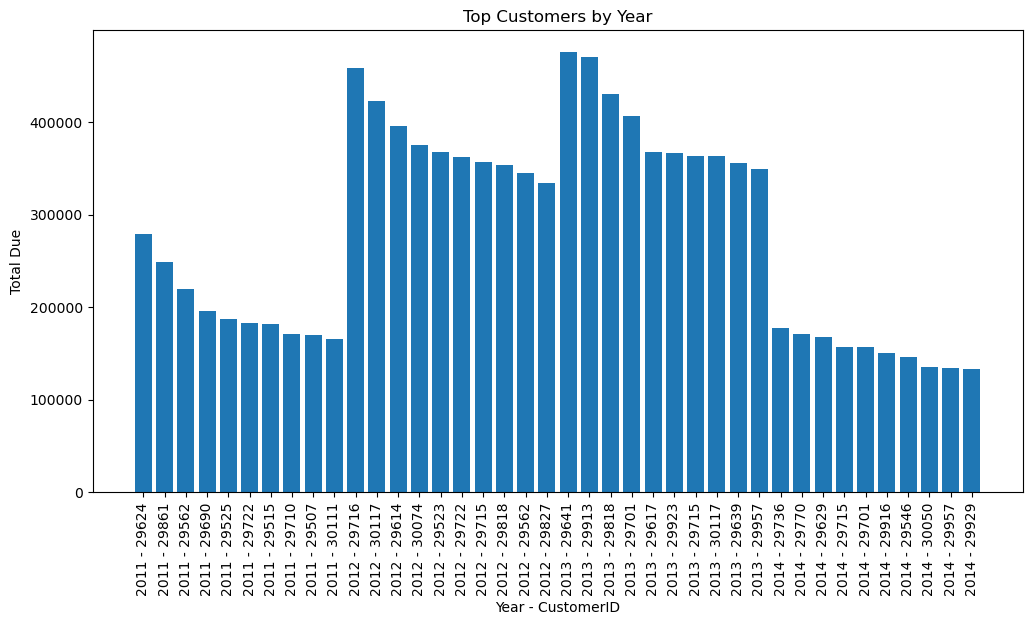

In [14]:
# 4x SQL queries to retrieve the top customers for each year
queries = [
    """
    SELECT TOP 10 CustomerID 
        , SUM(TotalDue) AS TotalDue
        , COUNT(SalesOrderID) AS TotalOrders
        , SUM(TotalDue) / COUNT(SalesOrderID) AS AvgOrderValue
    FROM Sales.SalesOrderHeader
    WHERE OrderDate BETWEEN '2011-05-31' AND '2011-12-31'
    GROUP BY CustomerID
    ORDER BY TotalDue DESC
    """,
    """
    SELECT TOP 10 CustomerID
        , SUM(TotalDue) AS TotalDue
        , COUNT(SalesOrderID) AS TotalOrders
        , SUM(TotalDue) / COUNT(SalesOrderID) AS AvgOrderValue
    FROM Sales.SalesOrderHeader
    WHERE OrderDate BETWEEN '2012-01-01' AND '2012-12-31'
    GROUP BY CustomerID
    ORDER BY TotalDue DESC
    """,
    """
    SELECT TOP 10 CustomerID
        , SUM(TotalDue) AS TotalDue
        , COUNT(SalesOrderID) AS TotalOrders
        , SUM(TotalDue) / COUNT(SalesOrderID) AS AvgOrderValue
    FROM Sales.SalesOrderHeader
    WHERE OrderDate BETWEEN '2013-01-01' AND '2013-12-31'
    GROUP BY CustomerID
    ORDER BY TotalDue DESC
    """,
    """
    SELECT TOP 10 CustomerID
        , SUM(TotalDue) AS TotalDue
        , COUNT(SalesOrderID) AS TotalOrders
        , SUM(TotalDue) / COUNT(SalesOrderID) AS AvgOrderValue
    FROM Sales.SalesOrderHeader
    WHERE OrderDate BETWEEN '2014-01-01' AND '2014-06-30'
    GROUP BY CustomerID
    ORDER BY TotalDue DESC
    """
]

#list to store the dataframes for each query
dataframes = []

#execute the queries and load the results into dataframes
for i, query in enumerate(queries): #i - index, query - sql code
    df = pd.read_sql(sql=query, con=connect)
    df['Year'] = 2011 + i  #assign year based on the query index, start on 0, thus end on 2014
    dataframes.append(df) #appends 'df' to 'dataframes' list, creating a list of dataframes

#concatenate the dataframes into one
result_df = pd.concat(dataframes)

#creating a bar chart to visualize the top customers by year
plt.figure(figsize=(12, 6))  #adjusts figure size

#customizing bar chart
#in plt.bar, first argument = x axis, second = y axis
plt.bar(result_df['Year'].astype(str) + ' - ' + result_df['CustomerID'].astype(str), result_df['TotalDue'])
plt.xlabel('Year - CustomerID')
plt.ylabel('Total Due')
plt.title('Top Customers by Year')
plt.xticks(rotation=90)  #for readability, 45 or 90


#display chart
plt.show()


In [13]:
#confidence interval for scrapped items, set MEAN and STDEV within SQL, define StandardError then calc using this SE.
#assuming n > 30 for all, but a few is not.
#this is for all 3 year, set yearly instead?


scrap_items ="""

SELECT
	ProductID
	, SUM(OrderQty) AS TotalQty
	, SUM(ScrappedQty) AS TotalScrapped
	, AVG(OrderQty) AS Mean
	, STDEV(OrderQty) AS STDV
	, COUNT(OrderQty) AS OrderCount

FROM Production.WorkOrder
GROUP BY ProductID
ORDER BY TotalScrapped DESC;

"""
#create new column SE to calculate CI's
scrap_df = pd.read_sql(sql=scrap_items, con=connect)
scrap_df['SE'] = scrap_df['STDV'] / np.sqrt(scrap_df['OrderCount'])
scrap_df['CI_HI'] = scrap_df['Mean'] + 1.96 * (scrap_df['STDV'] / scrap_df['SE'])
scrap_df['CI_LO'] = scrap_df['Mean'] - 1.96 * (scrap_df['STDV'] / scrap_df['SE'])
scrap_df.head(20)

,ProductID,TotalQty,TotalScrapped,Mean,STDV,OrderCount,SE,CI_HI,CI_LO
0,331,236002,1374,215,1146,1093,35,280,150
1,532,469468,1154,429,2277,1093,69,494,364
2,3,911890,1031,834,4143,1093,125,899,769
3,316,236002,736,215,1146,1093,35,280,150
4,350,118001,692,107,573,1093,17,172,42
5,324,234734,585,214,1139,1093,34,279,149
6,327,117367,571,107,569,1093,17,172,42
7,529,94218,422,86,433,1093,13,151,21
8,399,117367,348,107,569,1093,17,172,42
9,533,117367,342,107,569,1093,17,172,42
